# Relax Take-home Challenge
### Darren Lyles


The data is available as two attached CSV files:<br/>
takehome_user_engagement.csv<br/>
takehome_users.csv<br/>
The data has the following two tables:<br/>

1) A user table ("takehome_users") with data on 12,000 users who signed up for the<br/> 
product in the last two years. This table includes:<br/>
&emsp;&emsp;● name: the user's name<br/>
&emsp;&emsp;● object_id: the user's id<br/>
&emsp;&emsp;● email: email address<br/>
&emsp;&emsp;● creation_source: how their account was created. This takes on one of 5 values:<br/>
&emsp;&emsp;&emsp;&emsp;○ PERSONAL_PROJECTS: invited to join another user's personal workspace<br/>
&emsp;&emsp;&emsp;&emsp;○ GUEST_INVITE: invited to an organization as a guest (limited permissions)<br/>
&emsp;&emsp;&emsp;&emsp;○ ORG_INVITE: invited to an organization (as a full member)<br/>
&emsp;&emsp;&emsp;&emsp;○ SIGNUP: signed up via the website<br/>
&emsp;&emsp;&emsp;&emsp;○ SIGNUP_GOOGLE_AUTH: signed up using Google<br/>
Authentication (using a Google email account for their login id)<br/>
&emsp;&emsp;● creation_time: when they created their account<br/>
&emsp;&emsp;● last_session_creation_time: unix timestamp of last login<br/>
&emsp;&emsp;● opted_in_to_mailing_list: whether they have opted into receiving marketing emails<br/>
&emsp;&emsp;● enabled_for_marketing_drip: whether they are on the regular marketing email drip<br/>
&emsp;&emsp;● org_id: the organization (group of users) they belong to<br/>
&emsp;&emsp;● invited_by_user_id: which user invited them to join (if applicable).<br/>
2) A usage summary table ("takehome_user_engagement") that has a row for each day that a <br/>
user logged into the product.<br/><br/>

Defining an "adopted user" as a user who has logged into the product on three separate<br/> 
days in at least one seven­day period, identify which factors predict future user<br/> 
adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please<br/> 
send us a brief writeup of your findings (the more concise, the better ­­ no more than one<br/> 
page), along with any summary tables, graphs, code, or queries that can help us understand <br/>
your approach. Please note any factors you considered or investigation you did, even if<br/> 
they did not pan out. Feel free to identify any further research or data you think would<br/> 
be valuable.<br/>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The following interview challenge is to analyze the data on 12,000 users
who signed up for a product in the past two years. Based on the data given,
we want to predict whether a user is an 'adopted user' or not. We define an
adopted user as somebody who has logged into the product on three different
days in a seven day period.<br/><br/>

My solution will consist of three parts:<br/>
<ul>
    <li>Loading Data and Data Wrangling</li>
    <li>Exploratory Data Analysis</li>
    <li>Machine Learning</li>
</ul>

This is a supervised binary classification problem. Before we go into the modeling,
let's clean up the data and do some analysis first.

## Part 1 - Loading Data and Data Wrangling

In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Based on the summary given by the <code>info()</code> function for the user dataset, there will be some cleaning required. The columns, <code>last_session_creation_time</code> and <code>invited_by_user_id</code> have $73.5\%$ and $53.5\%$ of their columns filled with floating point values, respectively. To ease the data cleaning process, I will have these columns removed. The only useful information I found from <code>invited_by_user_id</code> is that $73.5\%$ of users were invited by to the product by an already existing user. This implies that the product team has a type of referral strategy to advertise and promote the product.

In [6]:
users_df.drop(['last_session_creation_time', 'invited_by_user_id'], inplace=True, axis=1)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
dtypes: int64(4), object(4)
memory usage: 750.1+ KB


For the user engagement dataset, let's set the index to the time_stamp column.

In [7]:
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])
user_engagement_df.set_index('time_stamp', inplace=True)
user_engagement_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


Now that we have cleaned both data sets, we can move forward to exploratory data analysis!

## Part 2 - Exploratory Data Analysis

We will be looking at both datasets to find any interesting facts, trends or behaviors. We first start out with analyzing the number of new user accounts created during the 2012 to 2014. 

In [8]:
user_creation_df = pd.DataFrame({'creation_time':users_df['creation_time'], 'count':1})
user_creation_df['creation_time'] = pd.to_datetime(user_creation_df['creation_time'])
user_creation_df.set_index('creation_time', inplace=True)
user_creation_df.head()

,count
creation_time,
2014-04-22 03:53:30,1
2013-11-15 03:45:04,1
2013-03-19 23:14:52,1
2013-05-21 08:09:28,1
2013-01-17 10:14:20,1


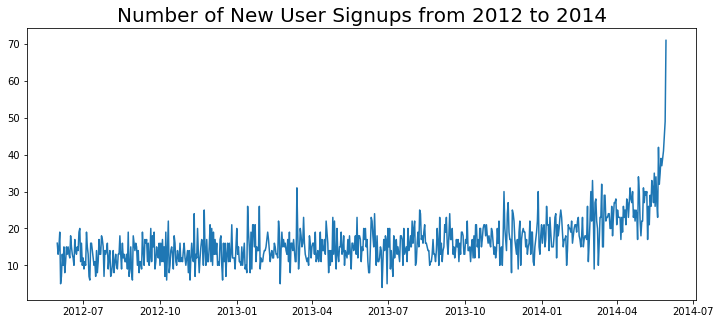

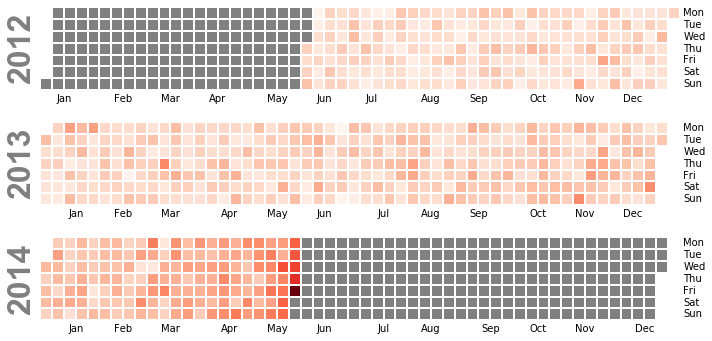

In [9]:
import calmap
user_creation_counts = user_creation_df.resample('D').count()
plt.figure(figsize=(12, 5))
plt.plot(user_creation_counts)
plt.title('Number of New User Signups from 2012 to 2014', fontsize=20)
plt.show()
calmap.calendarplot(user_creation_counts['count'], 
                    fillcolor='gray',
                    #cmap='YlGn',
                    fig_kws=dict(figsize=(10, 5)))
plt.show()

From the line plot and the calendar heatmap, we see mostly fluctuations of the number of new signups for the product. As we get near May 2014, the offset of the fluctuations begin to rise. This is likely due to a large enough user base such that product's 'invitation' method starts to become more effective in attracting more users.

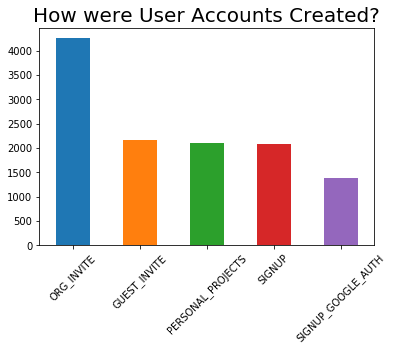

In [10]:
users_df['creation_source'].value_counts().plot.bar()
plt.title('How were User Accounts Created?', fontsize=20)
plt.xticks(rotation=45)
plt.show()

As the title above asks, how were user accounts created? Most user accounts were created by an organizational invite, the runner-up is by guest invite. The bottom three were because of personal projects, signup (without an invite), and signing up with a google account.

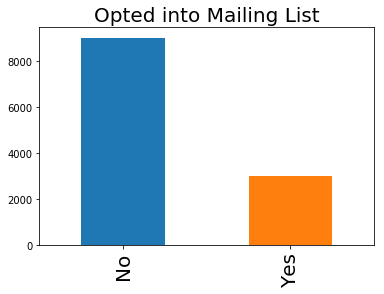

In [11]:
users_df['opted_in_to_mailing_list'].value_counts().plot.bar()\
.set_xticklabels(('No', 'Yes'), fontsize=20)
plt.title('Opted into Mailing List', fontsize=20)
plt.show()

Unfortunately, most users did not opt into the product's mailing list.

The following plots show the login behavior of all users from 2012 to 2014.

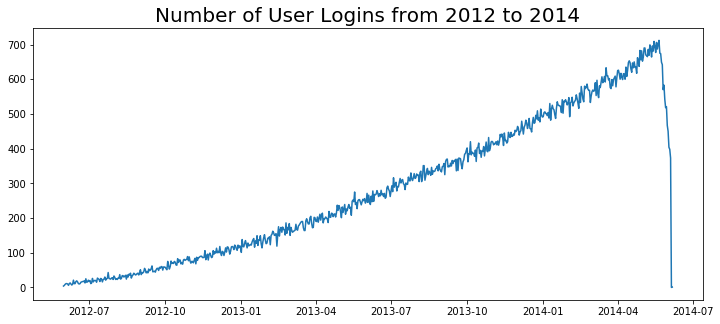

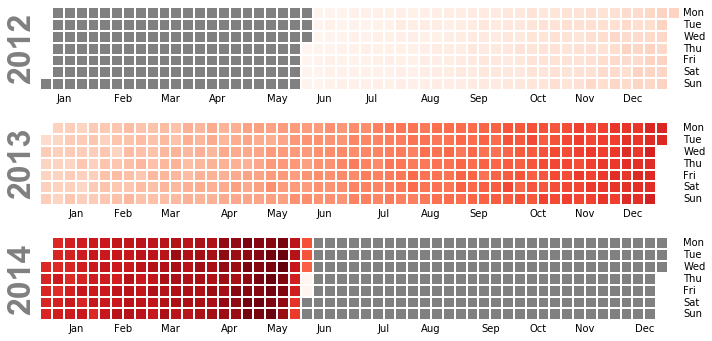

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(user_engagement_df.resample('D').count()['visited'])
plt.title('Number of User Logins from 2012 to 2014', fontsize=20)
plt.show()

calmap.calendarplot(user_engagement_df.resample('D').count()['visited'], 
                    fillcolor='gray',
                    #cmap='YlGn',
                    fig_kws=dict(figsize=(10, 5)))
plt.show()

Since the product is getting new users over time (and the assumption is that no user accounts were closed), we see a overall increasing trend in the number of logins from 2012 to 2014. The fluctuation in the trend would simply be a result of significantly more or less activity by a significant group of users.<br/><br/>
However, fluctuations in user login does not affect the overall trend. If we were to smooth out the line plot and focus on the trend, we can do so by week or by month. The trend is much more obvious in the line plots below.

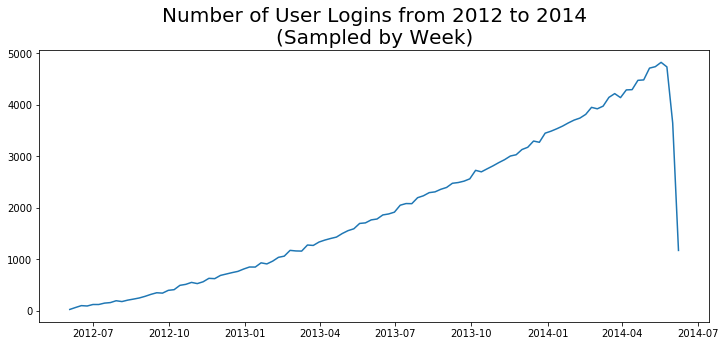

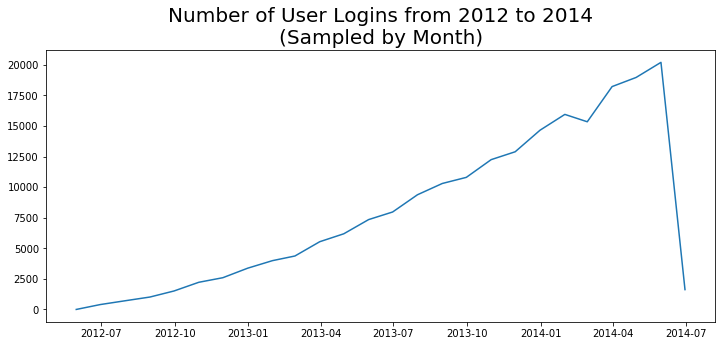

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(user_engagement_df.resample('W').count()['visited'])
plt.title('Number of User Logins from 2012 to 2014\n(Sampled by Week)', fontsize=20)
plt.figure(figsize=(12, 5))
plt.plot(user_engagement_df.resample('M').count()['visited'])
plt.title('Number of User Logins from 2012 to 2014\n(Sampled by Month)', fontsize=20)
plt.show()

## Part 3 - Machine Learning

The main objective is to which features contribute to predicting wether a user is an 
'adopted' user or not. This is a supervised learning problem which involves binary 
classification.

Let's start off by creating a new dataset which determines wether a user is an adopted 
user or not. An adopted user is defined as user which logs in to the product on three 
separate days within at least one seven day period. We will make sure that our new dataset 
satisfies this criterion.

In [14]:
user_engagement_df.reset_index(inplace=True)

In [15]:
adopted_users = {}
for group in user_engagement_df.groupby('user_id'):
    #Check to see if there are less than three visits per user
    if len(group[1]) < 3:
        adopted_users[group[0]] = 0
        continue
    
    #Check to see if the user is an adopted user or not
    for i, time_stamp in enumerate(group[1]['time_stamp']\
                                   .sort_values().reset_index(drop=True)):
        
        if i + 2 >= len(group[1]):
            break
            
        ##Create 7-Day Window
        begin_window = time_stamp
        end_window   = begin_window + pd.Timedelta('7D')
        
        if(group[1]['time_stamp']\
           .sort_values().reset_index(drop=True)[i+1] < end_window\
            and\
           group[1]['time_stamp']\
           .sort_values().reset_index(drop=True)[i+2] < end_window):
            adopted_users[group[0]] = 1
            break
        
        adopted_users[group[0]] = 0

In [16]:
#Number of 'adopted' users
sum(adopted_users.values())

1602

In [17]:
#Number of total users
len(adopted_users)

8823

After doing some preprocessing to obtain a dictionary which determines whether a user is us an adopted user or not, we noticed that there are 1602 adopted users and 8823 distinct users! We will have a class imbalance issue since 18% of the users are adopted.

In [18]:
adopted_users_df = pd.DataFrame({'object_id': list(adopted_users.keys()), 
                                 'adopted': list(adopted_users.values())})
adopted_users_df.head()

,object_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [19]:
merged_data = pd.merge(users_df, adopted_users_df, on='object_id', how='outer')

In [20]:
merged_data.dropna(inplace=True) #this is to drop users who were not represented in the
                                 #user_engagement dataset

In [21]:
merged_data.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,0.0


Before splitting the data set in to feature and target matrices, we will convert the creation_time column into a <code>datetime</code> format.

In [22]:
merged_data['creation_time'] = pd.to_datetime(merged_data['creation_time'])

Now we can drop unnecessary columns like name and email, and categorize the creation_source column.

In [23]:
merged_data.drop(['name', 'email'], axis=1, inplace=True)
merged_data['creation_source'] = merged_data['creation_source'].astype('category')

In [24]:
merged_data['creation_source'] = merged_data['creation_source'].cat.codes

Now we can get the feature and target variables.

In [25]:
X = merged_data.drop(['adopted', 'creation_time'], axis=1)
y = merged_data['adopted']

For the learning model, we will use logistic regression and look at feature imporances for determining wether a user is adopted or not.

In [26]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 7 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
creation_source               8823 non-null int8
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
adopted                       8823 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), int8(1)
memory usage: 491.1 KB


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)
print('Model Accuracy is {}%'\
      .format(round(accuracy_score(y_test, lr.predict(X_test)),2)))

Model Accuracy is 0.81%


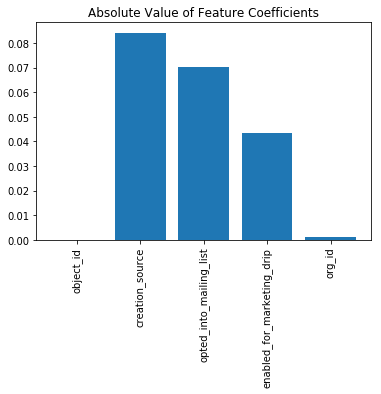

In [28]:
plt.bar(np.arange(len(lr.coef_[0])), abs(lr.coef_[0]), align='center')
plt.xticks(np.arange(5), ('object_id', 'creation_source', 'opted_into_mailing_list',
           'enabled_for_marketing_drip', 'org_id'), rotation=90)
plt.title('Absolute Value of Feature Coefficients')
plt.show()

After running logistic regression and analyzing the absolute value of the regression coefficients (this is how I evaluated feature importance), we see that <code>creation_source</code>, <code>opted_into_mailing_list</code>, and <code>enabled_for_marketing_drip</code> have the most predictive power to determine whether a user is adopted or not.